In [1]:
import os
import sys
from utils.nrel_uitls import CLIMATEZONES, RESTYPES
import json
from pathlib import Path
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

import matplotlib.pyplot as plt
import numpy as np
# import h5py
# from storage import upload_to_bucket

from schema import Schema
from whiteboxsim import WhiteboxSimulation
from shoeboxer.shoebox_config import ShoeboxConfiguration
from shoeboxer.builder import ShoeBox
from utils.constants import TimeSeriesOutput

from archetypal import settings

settings.energyplus_location = Path("D:\EnergyPlusV22-2-0")
settings.ep_version = "22.2.0"

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package energy-pandas is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
timeseries = [
    TimeSeriesOutput(
        name="DistrictCooling",
        # var_name="Cooling:DistrictCooling",
        key_name="Cooling:DistrictCooling",
        key="OUTPUT:METER",
        freq="Monthly",
        store_output=True,
    ),
    TimeSeriesOutput(
        name="DistrictHeating",
        key_name="Heating:DistrictHeating",
        key="OUTPUT:METER",
        freq="Monthly",
        store_output=True,
    ),
    TimeSeriesOutput(
        name="Supply Air Heating",
        var_name="Zone Ideal Loads Supply Air Total Heating Energy",
        key="OUTPUT:VARIABLE",
        freq="Hourly",
        store_output=True,
    ),
    TimeSeriesOutput(
        name="Supply Air Cooling",
        var_name="Zone Ideal Loads Supply Air Total Cooling Energy",
        key="OUTPUT:VARIABLE",
        freq="Hourly",
        store_output=True,
    ),
    TimeSeriesOutput(
        name="OA Heating",
        var_name="Zone Ideal Loads Outdoor Air Total Heating Energy",
        key="OUTPUT:VARIABLE",
        freq="Hourly",
        store_output=True,
    ),
    TimeSeriesOutput(
        name="OA Cooling",
        var_name="Zone Ideal Loads Outdoor Air Total Cooling Energy",
        key="OUTPUT:VARIABLE",
        freq="Hourly",
        store_output=True,
    ),
    #Zone Ideal Loads Supply Air Total Heating Energy 
    #Zone Ideal Loads Zone Total Heating Energy
]
schema = Schema(timeseries_outputs=timeseries)
# schema = Schema()

## Build shoeboxes using schema

Let's create a new sample synthetic shoebox with a storage vector

In [3]:
storage_vector = schema.generate_empty_storage_vector()
schema.update_storage_vector(storage_vector, parameter="climate_zone", value=CLIMATEZONES["2A"])
schema.update_storage_vector(storage_vector, parameter="base_epw", value=10)
schema.update_storage_vector(storage_vector, "height", 4)
schema.update_storage_vector(storage_vector, "width", 5)
schema.update_storage_vector(storage_vector, "floor_2_facade", 2.0)
schema.update_storage_vector(storage_vector, "core_2_perim", 1.5) # TODO: NOT UPDATING PROPERLY???
schema.update_storage_vector(storage_vector, "roof_2_footprint", 0.05)
schema.update_storage_vector(storage_vector, "ground_2_footprint", 0.5)
schema.update_storage_vector(storage_vector, "wwr", 0.3)
schema.update_storage_vector(storage_vector, "orientation", 0)
schema.update_storage_vector(storage_vector, "Infiltration", 1.0)
schema.update_storage_vector(storage_vector, "HeatingSetpoint", 18)
schema.update_storage_vector(storage_vector, "CoolingSetpoint", 24)
schema.update_storage_vector(storage_vector, "PeopleDensity", 0.05)
schema.update_storage_vector(storage_vector, "LightingPowerDensity", 3)
schema.update_storage_vector(storage_vector, "EquipmentPowerDensity", 7)
schema.update_storage_vector(storage_vector, "RoofRValue", 2)
schema.update_storage_vector(storage_vector, "SlabRValue", 2)
schema.update_storage_vector(storage_vector, "FacadeRValue", 2)
schema.update_storage_vector(storage_vector, "FacadeMass", 1) 
schema.update_storage_vector(storage_vector, "RoofMass", 0)
schema.update_storage_vector(storage_vector, "WindowUValue", 1.0) 
schema.update_storage_vector(storage_vector, "WindowShgc", 0.5) 
schema.update_storage_vector(storage_vector, "shading_seed", 2)
schema.update_storage_vector(storage_vector, "EconomizerSettings", 1)
schema.update_storage_vector(storage_vector, "RecoverySettings", 2)

In [4]:
from schedules import mutate_timeseries

shoebox_config = ShoeboxConfiguration()
shoebox_config.width = 10
shoebox_config.height = 10
shoebox_config.floor_2_facade = 0.9
shoebox_config.core_2_perim = 0.4
shoebox_config.roof_2_footprint = 0.25
shoebox_config.ground_2_footprint = 0.99
shoebox_config.wwr = 0.2
shoebox_config.orientation = 0
shoebox_config.shading_vect = np.random.random(12) * np.pi / 3

# MAKE FAKE SCHEDULES
schedules = np.zeros((3, 21))
# UNIRAND
# Equipment
schedules[0, 18] = 1  # hours per sample
schedules[0, 17] = 24 * 7  # samples per pattern
schedules[0, 16] = 0  # continuous
# Occupancy
schedules[1, 18] = 1  # hours per sample
schedules[1, 17] = 24  # samples per pattern
schedules[1, 16] = 0  # continuous
# Lights
schedules[2, 18] = 1  # hours per sample
schedules[2, 17] = 22  # samples per pattern
schedules[2, 16] = 0  # continuous
# build timeseries
scheds = mutate_timeseries(np.ones((3, 8760)), schedules, 0)

In [5]:
sb = ShoeBox.from_vector(
        name="test from vector",
        schema=schema,
        shoebox_config=shoebox_config,
        vector=storage_vector,
        schedules = scheds,
        # epw=Path("data/epws/city_epws_indexed", epw),
        output_directory=Path("cache")
        )
idf = sb.idf(run_simulation=False)

INFO:ShoeBox:Simulating in Seoul


INFO:shoeboxer.geometry_utils:New perimeter depth: 9.0
INFO:shoeboxer.geometry_utils:New core depth: 3.6
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving 4.0 m in y axis
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
INFO:shoeboxer.geometry_utils:Maximum shading point is 31.28699193822159
INFO:shoeboxer.geometry_utils:Placing shading around center point [5. 0.]
INFO:ShoeBox:Building idf for cache\test from vector.epjson
INFO:ShoeBox:EnergyPlus Starting
INFO:ShoeBox:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.10.22 21:29
INFO:ShoeBox:Converted input file format. Exiting.
INFO:ShoeBox:EnergyPlus Run Time=00hr 00min  0.10sec
INFO:ShoeBox:Command executed successfully.


In [6]:
idf.simulate()

D:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-test from vector.idf: 3.00it [00:00, 10.1it/s]
C:\EnergyPlusV22-2-0\energyplus.exe test from vector.idf: 64it [00:08,  7.11it/s]


<IDF object test from vector.idf
at cache\test from vector.idf
	Version 22.2.0
Simulation Info:
| SimulationIndex       | 1                                                           |
| EnergyPlusVersion     | EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.10.22 21:29 |
| TimeStamp             | YMD=2023.10.22 21:29                                        |
| NumTimestepsPerHour   | 6                                                           |
| Completed             | FALSE                                                       |
| CompletedSuccessfully | FALSE                                                       |
	Files at 'cache\e7a223b0cbebfb97472f1af335eba5c8'>

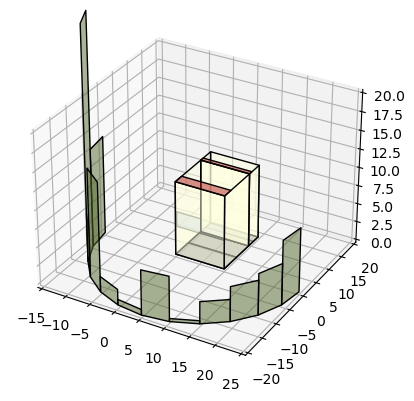

(<Figure size 640x480 with 1 Axes>, [<Axes3D: >])

In [7]:
idf.view_model()

## Error testing

In [ ]:
# with open("cache/monthly.hdf","wb") as store:
#     s3.download_fileobj("ml-for-bem", "single-climate-zone/v1/nyc/monthly.hdf", store)

In [7]:
import pandas as pd
from pathlib import Path
with pd.HDFStore("cache/monthly.hdf","r") as store:
    print(store)
    df = store["batch_results"]
schedules = np.load(
    Path(os.getcwd(), "data", "residential_schedules.npy")
)
with open(Path(os.getcwd(), "data", "city_map.json"), "r") as f:
    city_map = json.load(f)
epw = city_map["NY, New York"]["epw"]

<class 'pandas.io.pytables.HDFStore'>
File path: cache/monthly.hdf



In [8]:
df.head()

KeyValue                                                                                                                                                                                                                                                                                                                                                                                                                                 Core  \
Name                                                                                                                                                                                                                                                                                                                                                                                                                                  Heating   
                                                                                                                                                                                                                                                                                                                                                                                                                                   2018-01-01   
id                                   width     height   floor_2_facade core_2_perim roof_2_footprint ground_2_footprint wwr      orientation HeatingSetpoint CoolingSetpoint LightingPowerDensity EquipmentPowerDensity PeopleDensity Infiltration VentilationPerArea VentilationPerPerson VentilationMode FacadeMass RoofMass FacadeRValue RoofRValue SlabRValue EconomizerSettings RecoverySettings WindowU  WindowSHGC error                 
5c3f116d-8aa6-4379-a7a3-e9bffb392cc6 3.408388  4.299837 2.155641       1.125114     0.050394         0.061823           0.152975 2.0         14.982571       27.355843       14.252528            15.511459             0.170207      1.098342     2.539172           2.219063             2.0             3.0        3.0      11.830815    11.159809  1.448538   1.0                2.0              6.443281 0.623987   False  9.615249e+10   
fd3b78f4-d80d-435b-a7d5-0c94b6f64a18 4.874480  2.521299 2.162024       1.353322     0.615205         0.089299           0.461756 1.0         14.148930       16.565400       5.100191             16.708871             0.178440      2.413662     0.192994           0.312188             1.0             2.0        0.0      9.007163     11.962074  6.746764   1.0                1.0              2.556901 0.739624   False  5.719210e+10   
d555d5d6-6b92-4cab-af4e-e76848cd67d5 11.361027 3.195395 0.697579       1.538981     0.673207         0.055878           0.173377 3.0         17.441558       17.763088       1.716795             19.508584             0.321084      3.754270     1.576072           3.340577             0.0             0.0        3.0      9.059039     14.100986  4.484076   1.0                1.0              2.858497 0.260088   False  4.630771e+11   
3002bb26-4004-4423-9574-0928c26f1fbc 6.663318  2.933725 2.051717       0.837093     0.880001         0.926492           0.083242 2.0         18.094322       27.664855       18.460350            10.661301             0.210172      1.502174     3.030604           3.190301             0.0             2.0        1.0      9.524163     12.973898  2.089123   1.0                2.0              0.934983 0.433673   False  3.525773e+11   
50aff27c-d40e-40a1-aa78-a4b7e084de3e 7.542184  2.661247 1.785571       1.160299     0.839141         0.389746           0.536453 1.0         20.463207       23.575816       18.426919            13.589099             0.071412      2.822294     2.417921           2.737607             0.0             2.0        0.0      10.172696    8.661352   14.553176  1.0                0.0              5.517888 0.345117   False  1.314998e+12   

KeyValue                                                                                              

In [9]:
import boto3
BUCKET_NAME = 'ml-for-bem'
ERROR_PREFIX = "single-climate-zone/v1/nyc/errors/"

s3 = boto3.resource('s3')
bucket = s3.Bucket(BUCKET_NAME)

error_files = []
for obj in bucket.objects.filter(Prefix=ERROR_PREFIX):
    error_files.append(obj.key)

In [10]:
len(error_files)

89

In [11]:
# Get an error file and look at it
s3 = boto3.client('s3')
error_path = "cache/errors"
if not os.path.exists(error_path):
    os.makedirs(error_path)
    os.makedirs(Path(error_path, 'shoeboxes'))

In [ ]:

# Download all the error files
# for error_file in error_files:
#     filename = Path(error_path, error_file.split("/")[-1])
#     with open(filename, 'wb') as f:
#         s3.download_fileobj(BUCKET_NAME, error_file, f)

In [12]:
from shoeboxer.builder import template_dict

error_ids = [x.split("/")[-1].split(".")[0] for x in error_files]

def rebuild_sb(error_id):
        tuples = [(key, value)
                for i, (key, value) in enumerate(zip(list(df.loc[error_id].index.names), list(df.loc[error_id].index[0])))]
        shoebox_data = dict(tuples)
        td = template_dict(
                schedules=schedules,
                people_density=shoebox_data["PeopleDensity"],
                lighting_power_density=shoebox_data["LightingPowerDensity"],
                equipment_power_density=shoebox_data["EquipmentPowerDensity"],
                infiltration_per_area=shoebox_data["Infiltration"],
                ventilation_per_floor_area=shoebox_data["VentilationPerArea"],
                ventilation_per_person=shoebox_data["VentilationPerPerson"],
                ventilation_mode=shoebox_data["VentilationMode"],
                heating_sp=shoebox_data["HeatingSetpoint"],
                cooling_sp=shoebox_data["CoolingSetpoint"],
                heat_recovery=shoebox_data["RecoverySettings"],
                economizer=shoebox_data["EconomizerSettings"],
                wall_r_val=shoebox_data["FacadeRValue"],
                wall_mass=shoebox_data["FacadeMass"],
                roof_r_val=shoebox_data["RoofRValue"],
                roof_mass=shoebox_data["RoofMass"],
                slab_r_val=shoebox_data["SlabRValue"],
                shgc=shoebox_data["WindowSHGC"],
                window_u_val=shoebox_data["WindowU"],
                )

        shoebox_config = ShoeboxConfiguration()
        shoebox_config.width = shoebox_data["width"]
        shoebox_config.height = shoebox_data["height"]
        shoebox_config.floor_2_facade = shoebox_data["floor_2_facade"]
        shoebox_config.core_2_perim = shoebox_data["core_2_perim"]
        shoebox_config.roof_2_footprint = shoebox_data["roof_2_footprint"]
        shoebox_config.ground_2_footprint = shoebox_data["ground_2_footprint"]
        shoebox_config.wwr = shoebox_data["wwr"]
        shoebox_config.orientation = shoebox_data["orientation"]
        shoebox_config.shading_vect = np.zeros((12,))
        try:
                sb = ShoeBox(
                        name=error_id,
                        shoebox_config=shoebox_config,
                        epw=Path("data/epws/city_epws_indexed", epw),
                        template_dict=td,
                        output_directory=Path("cache", "errors", "shoeboxes")
                        )
        
                idf = sb.idf(run_simulation=False)
                _, monthly = sb.simulate(idf)
                errors = sb.error_report(idf)
        except ValueError as e:
                print(e)
                return None, None, None, None
        return idf, shoebox_data, monthly, errors

In [13]:
# make shoebox
idx = 0
idf, shoebox_data, _ , errors = rebuild_sb(error_ids[idx])

print(idf.sim_info["CompletedSuccessfully"][0])
idf.view_model()
idf.open_err()
idf.simulation_dir

DEBUG:ShoeBox:Changed orientation of relative north to 90
DEBUG:ShoeBox:New R-val = 1.0410745098042515 compared to desired 1.0527452315781463
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 1.0617464555056089 compared to desired 1.0527452315781463
DEBUG:ShoeBox:New R-val = 8.539466124661244 compared to desired 8.550561915612537
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 8.539466124661244 compared to desired 8.550561915612537
DEBUG:ShoeBox:New R-val = 7.523068627450979 compared to desired 7.511129065821537
DEBUG:ShoeBox:Mechanical ventilation schedule: OccupancySchedule
INFO:shoeboxer.geometry_utils:New perimeter depth: 2.8966015540336625
INFO:shoeboxer.geometry_utils:New core depth: 0.15055518560352624
ERROR:shoeboxer.geometry_utils:Depth is too small. Dropping shoebox.


Depth is too small.


AttributeError: 'NoneType' object has no attribute 'sim_info'

Try all the errors

In [14]:
errors = {}
warnings = {}
results = {}
for i, error_id in enumerate(error_ids):
    _, _, results[error_id], report = rebuild_sb(error_id)
    if report is not None:
        errors[error_id] = report[0]
        warnings[error_id] = report[1]
    if i > 15:
        break
        

DEBUG:ShoeBox:Changed orientation of relative north to 90
DEBUG:ShoeBox:New R-val = 1.0410745098042515 compared to desired 1.0527452315781463
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 1.0617464555056089 compared to desired 1.0527452315781463
DEBUG:ShoeBox:New R-val = 8.539466124661244 compared to desired 8.550561915612537
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 8.539466124661244 compared to desired 8.550561915612537
DEBUG:ShoeBox:New R-val = 7.523068627450979 compared to desired 7.511129065821537
DEBUG:ShoeBox:Mechanical ventilation schedule: OccupancySchedule
INFO:shoeboxer.geometry_utils:New perimeter depth: 2.8966015540336625
INFO:shoeboxer.geometry_utils:New core depth: 0.15055518560352624
ERROR:shoeboxer.geometry_utils:Depth is too small. Dropping shoebox.
DEBUG:ShoeBox:Changed orientation of relative north to 90
DEBUG:ShoeBox:New R-val = 15.835192156863076 compared to desired 15.830388330246246
DEBUG:ShoeBox:Recalculating r-values

Depth is too small.
Depth is too small.


INFO:shoeboxer.geometry_utils:New perimeter depth: 3.9765076714414707
INFO:shoeboxer.geometry_utils:New core depth: 7.223889051981768
INFO:shoeboxer.geometry_utils:Shifting core to perimeter -1.0234923285585293 m
DEBUG:shoeboxer.geometry_utils:Current window to wall ratio is 0.5 with height 2.4215658831235674
DEBUG:shoeboxer.geometry_utils:New window height will be 0.5107222601233871
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
DEBUG:shoeboxer.geometry_utils:Core depth of adiabatic and non-adiabatic: 6.831171975824191, 0.39271707615757734
DEBUG:shoeboxer.geometry_utils:Shifting adiabatic lines
DEBUG:shoeboxer.geometry_utils:Shifting core adiabatic lines
DEBUG:shoeboxer.geometry_utils:Shifting core ground adiabatic lines
INFO:shoeboxer.geometry_utils:Maximum shading point is 0.0
INFO:shoeboxer.geometry_utils:Placing shading around center point [4.83953004 0.        ]
INFO:ShoeBox:Building idf for cache\errors\shoeboxes\1280b044-bb0a-4c82-8e20-12f4889b8638.epjson
DEBUG:Shoe

Depth is too small.
Depth is too small.


INFO:shoeboxer.geometry_utils:New perimeter depth: 5.0647389251129304
INFO:shoeboxer.geometry_utils:New core depth: 8.26353429866639
INFO:shoeboxer.geometry_utils:Shifting core to perimeter 0.06473892511293045 m
DEBUG:shoeboxer.geometry_utils:Current window to wall ratio is 0.4999999999999999 with height 2.601178995822192
DEBUG:shoeboxer.geometry_utils:New window height will be 3.4294704776395375
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
DEBUG:shoeboxer.geometry_utils:Core depth of adiabatic and non-adiabatic: 3.50626215710031, 4.757272141566079
DEBUG:shoeboxer.geometry_utils:Shifting adiabatic lines
DEBUG:shoeboxer.geometry_utils:Shifting core adiabatic lines
DEBUG:shoeboxer.geometry_utils:Shifting core ground adiabatic lines
INFO:shoeboxer.geometry_utils:Maximum shading point is 0.0
INFO:shoeboxer.geometry_utils:Placing shading around center point [3.46906454 0.        ]
INFO:ShoeBox:Building idf for cache\errors\shoeboxes\15081501-8597-49a8-9cd2-a20842efe121.epjson


Depth is too small.
Depth is too small.


DEBUG:ShoeBox:New R-val = 14.776368627451308 compared to desired 14.77251429053412
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 14.776368627451308 compared to desired 14.77251429053412
DEBUG:ShoeBox:New R-val = 3.2467831978319786 compared to desired 3.2555233065850424
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 3.2467831978319786 compared to desired 3.2555233065850424
DEBUG:ShoeBox:New R-val = 13.728950980392156 compared to desired 13.73901671327483
DEBUG:ShoeBox:Mechanical ventilation schedule: Off
INFO:shoeboxer.geometry_utils:New perimeter depth: 9.652237897007552
INFO:shoeboxer.geometry_utils:New core depth: 7.650473250246111
INFO:shoeboxer.geometry_utils:Shifting core to perimeter 4.652237897007552 m
DEBUG:shoeboxer.geometry_utils:Current window to wall ratio is 0.5 with height 2.206231127726685
DEBUG:shoeboxer.geometry_utils:New window height will be 1.1875523564203903
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
DEBUG:shoe

Depth is too small.
Depth is too small.


DEBUG:ShoeBox:New R-val = 10.335192156863073 compared to desired 10.328552901480403
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 10.322037826256658 compared to desired 10.328552901480403
DEBUG:ShoeBox:New R-val = 5.246783197831977 compared to desired 5.235653398326017
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 5.242844173441735 compared to desired 5.235653398326017
DEBUG:ShoeBox:New R-val = 4.876009803921567 compared to desired 4.862562104134709
DEBUG:ShoeBox:Mechanical ventilation schedule: AllOn
INFO:shoeboxer.geometry_utils:New perimeter depth: 2.0950497452862735
INFO:shoeboxer.geometry_utils:New core depth: 0.17095613045532945
ERROR:shoeboxer.geometry_utils:Depth is too small. Dropping shoebox.
DEBUG:ShoeBox:Changed orientation of relative north to 90
DEBUG:ShoeBox:New R-val = 10.42342745098072 compared to desired 10.427275772537449
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 10.439684885080188 compared to desired 10

Depth is too small.
Depth is too small.


INFO:shoeboxer.geometry_utils:New perimeter depth: 1.621416236948468
INFO:shoeboxer.geometry_utils:New core depth: 0.22829893475684762
ERROR:shoeboxer.geometry_utils:Depth is too small. Dropping shoebox.
DEBUG:ShoeBox:Changed orientation of relative north to 270
DEBUG:ShoeBox:New R-val = 0.8351921568630751 compared to desired 0.8426917918893322
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 0.8514495909625426 compared to desired 0.8426917918893322
DEBUG:ShoeBox:New R-val = 4.710197831978319 compared to desired 4.718484313470851
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 4.730649051490515 compared to desired 4.718484313470851
DEBUG:ShoeBox:New R-val = 4.934833333333333 compared to desired 4.923691483946007
DEBUG:ShoeBox:Mechanical ventilation schedule: AllOn
INFO:shoeboxer.geometry_utils:New perimeter depth: 12.444600043997289
INFO:shoeboxer.geometry_utils:New core depth: 11.206398022010823
INFO:shoeboxer.geometry_utils:Shifting core to perimete

Depth is too small.


INFO:ShoeBox:EnergyPlus Starting
INFO:ShoeBox:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.10.19 13:48
INFO:ShoeBox:Converted input file format. Exiting.
INFO:ShoeBox:EnergyPlus Run Time=00hr 00min  0.11sec
INFO:ShoeBox:Command executed successfully.
D:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-2a4f7e45-7e99-4c49-a3a6-5ed1302ab252.idf: 3.00it [00:00, 15.9it/s]
C:\EnergyPlusV22-2-0\energyplus.exe 2a4f7e45-7e99-4c49-a3a6-5ed1302ab252.idf: 55it [00:04, 11.57it/s]
DEBUG:ShoeBox:Changed orientation of relative north to 270
DEBUG:ShoeBox:New R-val = 7.805780392157191 compared to desired 7.792637111358041
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 7.805780392157191 compared to desired 7.792637111358041
DEBUG:ShoeBox:New R-val = 4.490685636856368 compared to desired 4.49782680909423
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 4.486856987742063 compared to desired 4.49782680909423
DEBUG:ShoeBox:New R-val = 2.5230686274509804 compared to desired 2.528

Depth is too small.
Depth is too small.


In [15]:
working_errors = []
working_error_types = []

for id, err in errors.items():
    if len(err) > 0:
        working_errors.append(id)
        working_error_types.extend(err)

print(len(working_errors))
set(working_error_types)

0


set()

In [17]:
all_warnings = []
warnings_types = []
l = []
for id, err in warnings.items():
    for e in err:
        if "FixViewFactors" in e:
            print(e)
            l.append(id)
    if len(err) > 0:
        all_warnings.append(id)
        warnings_types.extend(err)

print(len(all_warnings))
set(warnings_types)

** Warning ** FixViewFactors: View factors not complete. Check for bad surface descriptions or unenclosed zone="CORE".
** Warning ** FixViewFactors: View factors not complete. Check for bad surface descriptions or unenclosed zone="CORE".
** Warning ** FixViewFactors: View factors not complete. Check for bad surface descriptions or unenclosed zone="CORE".
** Warning ** FixViewFactors: View factors not complete. Check for bad surface descriptions or unenclosed zone="CORE".
** Warning ** FixViewFactors: View factors not complete. Check for bad surface descriptions or unenclosed zone="CORE".
** Warning ** FixViewFactors: View factors not complete. Check for bad surface descriptions or unenclosed zone="CORE".
** Warning ** FixViewFactors: View factors not complete. Check for bad surface descriptions or unenclosed zone="CORE".
** Warning ** FixViewFactors: View factors not complete. Check for bad surface descriptions or unenclosed zone="CORE".
4


{'** Warning ** FixViewFactors: View factors not complete. Check for bad surface descriptions or unenclosed zone="CORE".',
 '** Warning ** GetPurchasedAir: ZoneHVAC:IdealLoadsAirSystem="CORE IDEAL LOADS AIR missing data',
 '** Warning ** GetPurchasedAir: ZoneHVAC:IdealLoadsAirSystem="PERIMETER IDEAL LOADS AIR missing data',
 '** Warning ** Output:Meter: invalid Key Name="BASEBOARD:ENERGYTRANSFER" - not found.',
 '** Warning ** Output:Meter: invalid Key Name="COOLING:ELECTRICITY" - not found.',
 '** Warning ** Output:Meter: invalid Key Name="COOLING:GAS" - not found.',
 '** Warning ** Output:Meter: invalid Key Name="COOLINGCOILS:ENERGYTRANSFER" - not found.',
 '** Warning ** Output:Meter: invalid Key Name="FANS:ELECTRICITY" - not found.',
 '** Warning ** Output:Meter: invalid Key Name="GAS:FACILITY" - not found.',
 '** Warning ** Output:Meter: invalid Key Name="HEATING:ELECTRICITY" - not found.',
 '** Warning ** Output:Meter: invalid Key Name="HEATING:GAS" - not found.',
 '** Warning **

DEBUG:ShoeBox:Changed orientation of relative north to 0
DEBUG:ShoeBox:New R-val = 13.65872156862778 compared to desired 13.659413970422145
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 13.654065184122759 compared to desired 13.659413970422145
DEBUG:ShoeBox:New R-val = 7.295563685636854 compared to desired 7.29736838767292
DEBUG:ShoeBox:Recalculating r-values...
DEBUG:ShoeBox:New R-val = 7.29173503652255 compared to desired 7.29736838767292
DEBUG:ShoeBox:New R-val = 5.228950980392156 compared to desired 5.224444576759564
DEBUG:ShoeBox:Mechanical ventilation schedule: Off
INFO:shoeboxer.geometry_utils:New perimeter depth: 3.9765076714414707
INFO:shoeboxer.geometry_utils:New core depth: 7.223889051981768
INFO:shoeboxer.geometry_utils:Shifting core to perimeter -1.0234923285585293 m
DEBUG:shoeboxer.geometry_utils:Current window to wall ratio is 0.5 with height 2.4215658831235674
DEBUG:shoeboxer.geometry_utils:New window height will be 0.5107222601233871
INFO:shoeboxer.

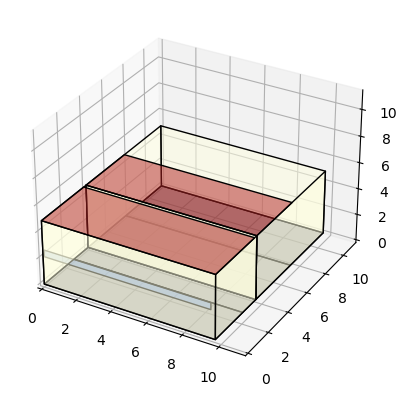

(<Figure size 640x480 with 1 Axes>, [<Axes3D: >])

In [19]:
idf, shoebox_data, monthly, errors = rebuild_sb(l[0])
idf.view_model()

INFO:shoeboxer.geometry_utils:New perimeter depth: 3.9201253580252877
INFO:shoeboxer.geometry_utils:New core depth: 0.19733339730961683
INFO:shoeboxer.geometry_utils:Shifting core to perimeter -1.0798746419747123 m
INFO:shoeboxer.geometry_utils:Current window to wall ratio is 0.5 with height 2.6959393660506024
INFO:shoeboxer.geometry_utils:New window height will be 3.092227154169712
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
INFO:shoeboxer.geometry_utils:Maximum shading point is 0.0
INFO:shoeboxer.geometry_utils:Placing shading around center point [3.38782033 0.        ]
INFO:ShoeBox:Building idf for cache\errors\shoeboxes\0fffe5ca-1d03-49f9-b8f3-103c5a477eb0.epjson
INFO:ShoeBox:EnergyPlus Starting
INFO:ShoeBox:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.10.14 15:05
INFO:ShoeBox:Converted input file format. Exiting.
INFO:ShoeBox:EnergyPlus Run Time=00hr 00min  0.09sec
INFO:ShoeBox:Command executed successfully.
D:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-0fffe5ca-1d03

FALSE


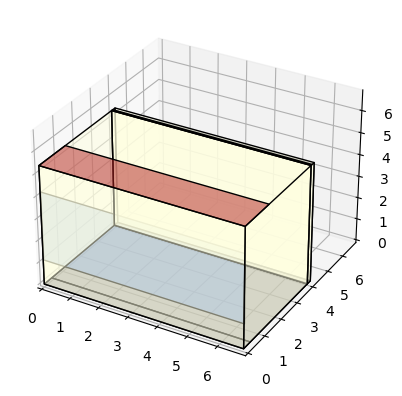

Path('cache\\477a984713ad0d8ce5129cfa4ae395bf\\f9328a6279af85866cc14bb37adba154')

In [34]:
tuples = [(key, value)
    for i, (key, value) in enumerate(zip(list(df.loc[working_errors[0]].index.names), list(df.loc[working_errors[0]].index[0])))]
shoebox_data = dict(tuples)
td = template_dict(
        schedules=schedules,
        people_density=shoebox_data["PeopleDensity"],
        lighting_power_density=shoebox_data["LightingPowerDensity"],
        equipment_power_density=shoebox_data["EquipmentPowerDensity"],
        infiltration_per_area=shoebox_data["Infiltration"],
        ventilation_per_floor_area=shoebox_data["VentilationPerArea"],
        ventilation_per_person=shoebox_data["VentilationPerPerson"],
        ventilation_mode=shoebox_data["VentilationMode"],
        heating_sp=shoebox_data["HeatingSetpoint"],
        cooling_sp=shoebox_data["CoolingSetpoint"],
        heat_recovery=shoebox_data["RecoverySettings"],
        economizer=shoebox_data["EconomizerSettings"],
        wall_r_val=shoebox_data["FacadeRValue"],
        wall_mass=shoebox_data["FacadeMass"],
        roof_r_val=shoebox_data["RoofRValue"],
        roof_mass=shoebox_data["RoofMass"],
        slab_r_val=shoebox_data["SlabRValue"],
        shgc=shoebox_data["WindowSHGC"],
        window_u_val=shoebox_data["WindowU"],
        )

shoebox_config = ShoeboxConfiguration()
shoebox_config.width = shoebox_data["width"]
shoebox_config.height = shoebox_data["height"]
shoebox_config.floor_2_facade = shoebox_data["floor_2_facade"]
shoebox_config.core_2_perim = shoebox_data["core_2_perim"]
shoebox_config.roof_2_footprint = shoebox_data["roof_2_footprint"]
shoebox_config.ground_2_footprint = 0.1#shoebox_data["ground_2_footprint"]
shoebox_config.wwr = shoebox_data["wwr"]
shoebox_config.orientation = shoebox_data["orientation"]
shoebox_config.shading_vect = np.zeros((12,))

sb = ShoeBox(
        name=error_ids[idx],
        shoebox_config=shoebox_config,
        epw=Path("data/epws/city_epws_indexed", epw),
        template_dict=td,
        output_directory=Path("cache", "errors", "shoeboxes")
        )
idf = sb.idf(run_simulation=False)
_, monthly = sb.simulate(idf)
print(sb.error_report(idf))

# print(idf.sim_info["CompletedSuccessfully"][0])
idf.view_model()
idf.open_err()

## Compare UMI shoebox to whitebox

Load a few random umi shoeboxes

In [3]:
from umi.umi_surrogate import UmiSurrogate
umi_path = "D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Sample/SampleBuildings.umi"
energy_results_path = "C:/Users/zoele/Git_Repos/ml-for-building-energy-modeling/umi_data/SampleBuildings/eplus"
umi = UmiSurrogate.open(
    umi_path=umi_path, 
    schema=schema,
    compute_loss=True,
    energy_results_path=energy_results_path,
    checkpoint="deeper_output_net_with_leaky_relus_resumed/deeper_output_net_with_leaky_relus_resumed_202307232139_000_350000.pt")
# Load energy results
new_p = "D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/umi_data/Sample/SampleBuildings/eplus"
umi.set_energy_path(new_p)
umi.fetch_raw_shoebox_results(override=False)
print(umi.shoeboxdf.shape)
umi.shoeboxdf.head()

INFO:Storage:Successfully fetched bucket location
INFO:UmiSurrogate:Umi shoebox hourly energy will be saved in d:\Users\zoelh\GitRepos\ml-for-building-energy-modeling\ml-for-bem\umi\energy
INFO:UmiSurrogate:Opening umi project. This may take a few moments...
INFO:UmiSurrogate:Project name: SampleBuildings
INFO:UmiSurrogate:Setting up umi surrogate...
INFO:UmiSurrogate:Extracting climate data from umi project.
INFO:UmiSurrogate:Successfully loaded EPW file Data for [Boston Logan IntL Arpt]
INFO:UmiSurrogate:Climate vector loaded with shape (7, 8760)
INFO:UmiSurrogate:Collecting data from building templates...
INFO:UmiSurrogate:Hourly output already calculated and saved under d:\Users\zoelh\GitRepos\ml-for-building-energy-modeling\ml-for-bem\umi\energy\SampleBuildings_shoeboxhourlyresults.hdf5.


(364, 25)


,ParentBuildingId,PerimeterAreaWeight,CoreAreaWeight,PerimeterArea,CoreArea,Orientation,ClusterId,Roof2FloorRatio,Ground2FloorRatio,Floor2Fac,...,Height,Name,Occupancy,TemplateName,UseType,WwrE,WwrN,WwrS,WwrW,geometry
0,45528662-89aa-7b48-8da3-1153c0ecbd22,258.010417,344.437341,1255.630962,1676.23538,West,Group0,0.25,0.25,0.820404,...,13.122101,3633.0,586,PROG_00_VINTAGE_03_MASS_0,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((3548.30123 927.87828, 3553.338..."
1,45528662-89aa-7b48-8da3-1153c0ecbd22,23.925238,31.939584,1255.630962,1676.23538,West,Group0,0.25,0.25,0.820404,...,13.122101,3633.0,586,PROG_00_VINTAGE_03_MASS_0,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((3548.30123 927.87828, 3553.338..."
2,45528662-89aa-7b48-8da3-1153c0ecbd22,319.021121,425.885078,1255.630962,1676.23538,North,Group0,0.25,0.25,0.820404,...,13.122101,3633.0,586,PROG_00_VINTAGE_03_MASS_0,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((3548.30123 927.87828, 3553.338..."
3,45528662-89aa-7b48-8da3-1153c0ecbd22,27.396955,36.574237,1255.630962,1676.23538,North,Group0,0.25,0.25,0.820404,...,13.122101,3633.0,586,PROG_00_VINTAGE_03_MASS_0,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((3548.30123 927.87828, 3553.338..."
4,45528662-89aa-7b48-8da3-1153c0ecbd22,344.588024,460.016242,1255.630962,1676.23538,South,Group0,0.25,0.25,0.820404,...,13.122101,3633.0,586,PROG_00_VINTAGE_03_MASS_0,Uncategorized,0.4,0.4,0.4,0.4,"MULTIPOLYGON (((3548.30123 927.87828, 3553.338..."


In [14]:
umi.shoeboxdf.describe()

,PerimeterAreaWeight,CoreAreaWeight,PerimeterArea,CoreArea,Roof2FloorRatio,Ground2FloorRatio,Floor2Fac,Core2Perimeter,FloorCount,GrossFloorArea,Height,Occupancy,WwrE,WwrN,WwrS,WwrW
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,3.640000e+02,3.640000e+02,3.640000e+02,3.640000e+02
mean,568.041022,2153.519976,8684.207401,36497.078850,0.177632,0.177632,0.861698,2.626115,7.659341,45181.286209,24.424462,9035.854396,4.000000e-01,4.000000e-01,4.000000e-01,4.000000e-01
std,901.819832,4713.689941,10364.351761,63505.142585,0.113584,0.113584,0.088843,1.721833,3.825303,73435.705786,11.389749,14687.158147,1.114040e-16,1.114040e-16,1.114040e-16,1.114040e-16
min,0.327075,0.361244,454.186678,196.363940,0.055556,0.055556,0.599544,0.368690,2.000000,723.081980,6.637939,144.000000,4.000000e-01,4.000000e-01,4.000000e-01,4.000000e-01
25%,36.142962,55.120215,1833.911233,2018.855412,0.100000,0.100000,0.787979,1.340236,4.000000,3830.421216,13.702490,765.750000,4.000000e-01,4.000000e-01,4.000000e-01,4.000000e-01
50%,212.101876,385.682416,5078.664635,12548.857908,0.125000,0.125000,0.894969,2.576206,8.000000,19408.036779,25.205688,3881.000000,4.000000e-01,4.000000e-01,4.000000e-01,4.000000e-01
75%,759.731562,2178.568770,8884.117465,32906.896460,0.250000,0.250000,0.931867,3.001238,10.000000,39794.910045,32.650970,7958.000000,4.000000e-01,4.000000e-01,4.000000e-01,4.000000e-01
max,6526.432721,38703.612923,39241.892655,225903.429199,0.500000,0.500000,0.969924,6.893849,18.000000,265145.321854,56.109314,53029.000000,4.000000e-01,4.000000e-01,4.000000e-01,4.000000e-01


In [6]:
# shoeboxes = umi._fetch_shoeboxcollection()

INFO:UmiSurrogate:Fetching shoebox IDFs.
INFO:UmiSurrogate:Completed fetching shoebox IDFs in 29 seconds.


Rebuild shoeboxes with whitebox

In [5]:
building_vector, timeseries_vector_norm, results_vector_norm = umi.make_umi_dataset(0, umi.shoeboxdf.shape[0])

INFO:UmiSurrogate:AREA MAX: 65.44307243115168, MIN 7.407526058353017
INFO:UmiSurrogate:PERIM AREA MAX: 8.729319501833006, MIN 5.395899379773882
INFO:UmiSurrogate:CORE AREA MAX: 16.050894925787496, MIN -2.329457773806955
INFO:UmiSurrogate:Loaded Shoebox Geometry Array. Shape=(364, 14)
INFO:UmiSurrogate:Setting up template lookup for groups...
INFO:UmiSurrogate:Loaded Schedules Array. Shape=(32, 3, 8760)
INFO:UmiSurrogate:Templates's geometry parameters shape=(32, 21)
INFO:UmiSurrogate:Constructing machine learning vectors...
INFO:UmiSurrogate:Building vector shape: (364, 35)


INFO:UmiSurrogate:Summed results to shape (364, 2, 2, 12)
INFO:UmiSurrogate:RESULTS PERIM HEATING MAX: 353.2109366002006, MIN: 0.0
INFO:UmiSurrogate:RESULTS PERIM COOLING MAX: 515.3163804589813, MIN: 0.0
INFO:UmiSurrogate:RESULTS CORE HEATING MAX: 536.3028530008636, MIN: 0.0
INFO:UmiSurrogate:RESULTS CORE COOLING MAX: 292.13737393091924, MIN: 0.0
INFO:UmiSurrogate:Results vector shape: (364, 4, 12)
INFO:UmiSurrogate:Timeseries vector shape: (364, 11, 8760)


In [35]:
np.set_printoptions(suppress=True)
print(building_vector.max(axis=0))
print(np.max(timeseries_vector_norm, axis=(0, 2)))
print(results_vector_norm.max(axis=(0, 2)))

[   0.            0.14285714    0.27642611    3.69937811    0.5
    0.5           0.4           1.            1.            1.
    1.            0.6           0.5           0.1715        0.18729097
    0.4        1160.            0.            0.            0.
    1.            0.            1.            0.            1.
    0.            0.            0.16049997    0.28439368    0.30547269
  225.            0.87041368    0.70378775    0.12218549    0.21078553]
[   0.84941176    1.            0.94370861    0.835         0.88969918
    0.73730044    0.95906272 1041.4           0.698         0.923
    0.966     ]
[0.28346803 0.60979916 4.32065023 2.63631558]


In [ ]:
whitebox_sim = WhiteboxSimulation(schema, storage_vector)
ep_df_hourly, ep_df_monthly = whitebox_sim.simulate()

In [ ]:
def build_whitebox_from_umi(shoebox, out_dir):
    shoebox_config = ShoeboxConfiguration.from_umi(shoebox)
    epw = None    
    sb = ShoeBox(
        name="test",
        shoebox_config=shoebox_config,
        epw=epw,
        output_directory=out_dir,
    )
    template_dict=get_template_dict_from_archetypal()
    idf = sb.update_epjson(template_dict, change_summary=False, run_simulation=True)
    # idf.view_model()
    return idf

In [7]:
from archetypal.template.constructions.opaque_construction import OpaqueConstruction
from archetypal.template.constructions.window_construction import WindowConstruction
from archetypal.schedule import Schedule
from schedules import update_schedule_objects, schedule_paths

def sb_height(sb):
    for s in sb.getsurfaces():
        if s.Surface_Type == "Wall":
            vertices_idx = [i for i, x in enumerate(vars(s)['objls']) if "Zcoordinate" in x]
            z_idxs = []
            try:
                for i in vertices_idx:
                    z_idxs.append(vars(s)["obj"][i])
            except:
                h = max(z_idxs) - min(z_idxs)
                break
    return h
    

def build_whitebox_from_umi(
        shoebox,
        floor_2_facade, 
        core_2_perim, 
        roof_2_footprint, 
        ground_2_footprint,
        cz=CLIMATEZONES["2A"], 
        vintage=1920, 
        program=RESTYPES["Multi-Family with 5+ Units"], 
        base_epw=city_map["CA, Los Angeles"]["idx"]
        ):

    # Reposition shoebox at origin
    sb = shoebox
    sb.translate_to_origin()

    storage_vector = schema.generate_empty_storage_vector()

    schema.update_storage_vector(storage_vector, parameter="climate_zone", value=cz)
    schema.update_storage_vector(storage_vector, parameter="vintage", value=vintage)
    schema.update_storage_vector(storage_vector, parameter="program_type", value=program)
    schema.update_storage_vector(storage_vector, parameter="base_epw", value=base_epw)
    schema.update_storage_vector(storage_vector, "height", sb_height(sb))
    schema.update_storage_vector(storage_vector, "width", sb.width)
    schema.update_storage_vector(storage_vector, "floor_2_facade", floor_2_facade)
    schema.update_storage_vector(storage_vector, "core_2_perim", core_2_perim)
    schema.update_storage_vector(storage_vector, "roof_2_footprint", roof_2_footprint)
    schema.update_storage_vector(storage_vector, "ground_2_footprint", ground_2_footprint)
    schema.update_storage_vector(storage_vector, "wwr", sb.wwr().iloc[0]["wwr_rounded_%"]/100)
    # NOTE AZIMUTH IS ROUNDED
    windows = sb.getsubsurfaces()
    orientation = (180 - round(windows[0].azimuth))/90 # TODO check what south means??
    schema.update_storage_vector(storage_vector, "orientation", orientation)
    schema.update_storage_vector(storage_vector, "Infiltration", sb.idfobjects['ZONEINFILTRATION:DESIGNFLOWRATE'][0].Air_Changes_per_Hour)
    schema.update_storage_vector(storage_vector, "HeatingSetpoint", [x for x in sb.idfobjects['SCHEDULE:CONSTANT'] if x.Name == "PerimHeating_SP_Sch"][0].Hourly_Value)
    schema.update_storage_vector(storage_vector, "CoolingSetpoint", [x for x in sb.idfobjects['SCHEDULE:CONSTANT'] if x.Name == "PerimCooling_SP_Sch"][0].Hourly_Value)
    schema.update_storage_vector(storage_vector, "PeopleDensity", sb.idfobjects['PEOPLE'][0].People_per_Zone_Floor_Area)
    schema.update_storage_vector(storage_vector, "LightingPowerDensity", sb.idfobjects['LIGHTS'][0].Watts_per_Zone_Floor_Area)
    schema.update_storage_vector(storage_vector, "EquipmentPowerDensity", sb.idfobjects['ELECTRICEQUIPMENT'][0].Watts_per_Zone_Floor_Area)
    
    roof_r = None
    wall_r = None
    slab_r = None
    roof_m = None
    wall_m = None
    slab_m = None
    for s in sb.getsurfaces():
        if s.Surface_Type.lower() == "roof" and roof_r is None:
            c = s.get_referenced_object("Construction_Name")
            oc = OpaqueConstruction.from_epbunch(c)
            roof_r = oc.u_factor
            roof_m = oc.heat_capacity_per_unit_wall_area
        if s.Surface_Type.lower() == "wall" and wall_r is None:
            c = s.get_referenced_object("Construction_Name")
            oc = OpaqueConstruction.from_epbunch(c)
            wall_r = oc.u_factor
            wall_m = oc.heat_capacity_per_unit_wall_area
        if s.Surface_Type.lower() == "floor" and slab_r is None:
            c = s.get_referenced_object("Construction_Name")
            oc = OpaqueConstruction.from_epbunch(c)
            slab_r = oc.u_factor
    
    schema.update_storage_vector(storage_vector, "RoofRValue", roof_r)
    schema.update_storage_vector(storage_vector, "SlabRValue", slab_r)
    schema.update_storage_vector(storage_vector, "FacadeRValue", wall_r)
    schema.update_storage_vector(storage_vector, "FacadeMass", wall_m) 
    schema.update_storage_vector(storage_vector, "RoofMass", roof_m)

    w = sb.idfobjects['FENESTRATIONSURFACE:DETAILED'][0].get_referenced_object("Construction_Name")
    window = WindowConstruction.from_epbunch(w)
    uval = window.u_factor
    try:
        shgc = window.shgc()
    except:
        tsol = window.Layers[0].Material.SolarTransmittance
        shgc = WindowParameter.single_pane_shgc_estimation(tsol=tsol, uval=uval)

    schema.update_storage_vector(storage_vector, "WindowSettings", np.array([uval,shgc])) 

    # schema.update_storage_vector(storage_vector, "shading_seed", 2) TODO
    schema.update_storage_vector(storage_vector, "EconomizerSettings", 1)
    schema.update_storage_vector(storage_vector, "RecoverySettings", 2)

    whitebox_sim = WhiteboxSimulation(schema, storage_vector)

    # Extract schedules vectors - ORDER MATTERS
    eqip_sched = Schedule.from_epbunch(sb.idfobjects['ELECTRICEQUIPMENT'][0].get_referenced_object("Schedule_Name")).series.to_numpy()
    lght_sched = Schedule.from_epbunch(sb.idfobjects['LIGHTS'][0].get_referenced_object("Schedule_Name")).series.to_numpy()
    occ_sched = Schedule.from_epbunch(sb.idfobjects['PEOPLE'][0].get_referenced_object("Number_of_People_Schedule_Name")).series.to_numpy()

    update_schedule_objects(
        whitebox_sim.template,
        timeseries=np.stack((eqip_sched, lght_sched, occ_sched)),
        zones=["Perimeter"],
        paths=schedule_paths,
        id=0,
    )
    update_schedule_objects(
        whitebox_sim.template,
        timeseries=np.stack((eqip_sched, lght_sched, occ_sched)),
        zones=["Core"],
        paths=schedule_paths,
        id=0,
    )

    whitebox_sim.template.Perimeter.Conditioning.MechVentSchedule = (
        whitebox_sim.template.Perimeter.Loads.OccupancySchedule
    )
    whitebox_sim.template.Perimeter.DomesticHotWater.WaterSchedule = (
        whitebox_sim.template.Perimeter.Loads.OccupancySchedule
    )

    whitebox_sim.shoebox.idfobjects['SHADING:BUILDING:DETAILED'] = sb.idfobjects['SHADING:BUILDING:DETAILED']
    
    return whitebox_sim

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\pandas\core\dtypes\inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\pandas\core\dtypes\inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\pandas\io\formats\printing.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a mu

ParentBuildingId                    f861f480-e8eb-9741-b2cc-e1d81ab0b6e6
PerimeterAreaWeight                                              7.56695
CoreAreaWeight                                                 21.649585
PerimeterArea                                                 6235.34062
CoreArea                                                    17839.755705
Orientation                                                        South
ClusterId                                                         Group6
Roof2FloorRatio                                                 0.166667
Ground2FloorRatio                                               0.166667
Floor2Fac                                                       0.902471
Core2Perimeter                                                  2.861072
ShoeboxPath            D:\Users\zoelh\GitRepos\ml-for-building-energy...
id                                  f861f480-e8eb-9741-b2cc-e1d81ab0b6e6
FloorCount                                         

INFO:Schema:Skipping update of window parameters - will build simple window in build_shoebox
INFO:Schema:height = 3.0920000000000023, width = 6.2215000000001055, perim_depth = 2.790439929009152, core_depth = 2.650917932558694
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-5bdd5c3a-5c9b-11ee-bfc6-004e01c02093.idf: 4.00it [00:00, 19.0it/s]
C:\EnergyPlusV9-2-0\energyplus.exe 5bdd5c3a-5c9b-11ee-bfc6-004e01c02093.idf: 55it [00:02, 21.81it/s]




------------------------------
EPW: d:\Users\zoelh\GitRepos\ml-for-building-energy-modeling\ml-for-bem\data\epws\city_epws_indexed\cityidx_0000_USA_CA-Climate Zone 9.722880_CTZRV2.epw
Selected Template: PROG_03_VINTAGE_00_MASS_1
---ShoeboxConfig---
Height 3.0920000000000023
Width 6.2215000000001055
WWR 0.4
Floor2Facade 0.9024708696666074
Core2Perim 0.95
Foot2Gnd [adia %] 0.16666666666666535
Roof2Gnd [adia %] 0.16666666666666535
Orientation -0.2
---PERIM/CORE Values---
Heating Setpoint: 20.0 20.0
Cooling Setpoint: 26.0 26.0
Equipment Power Density: 4.41 4.41
Lighting Power Density: 3.43 3.43
People Density: 0.2 0.2
Infiltration: 0.872 0.872
Roof HeatCap: 230221.09285714285 230221.09285714285
Facade HeatCap: 229496.78921080232 229496.78921080232
U Window: 300.0
Roof RSI: 0.3
Facade RSI: 0.4810197668599562
Slab RSI: 0.29999999999999993
Partition RSI: 0.6526162790697675
Ground RSI: 0.29999999999999993
Roof Assembly: [12:Concrete_Dense_1 with thickness of 0.100 m, 19:Plywood_Board with th

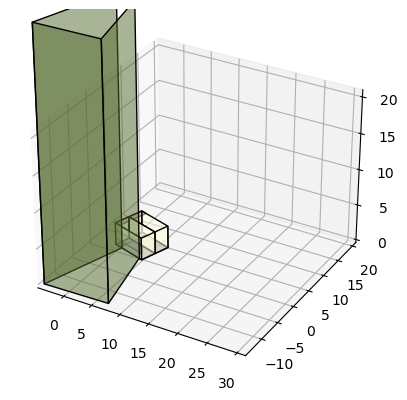

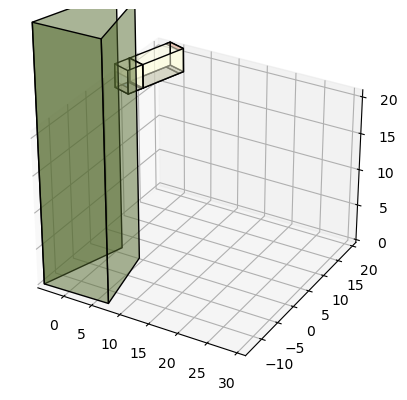

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\pandas\core\dtypes\inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\pandas\core\dtypes\inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\pandas\io\formats\printing.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a mu

ParentBuildingId                    40c15cd0-0276-7b46-85cc-6434d4cb8410
PerimeterAreaWeight                                           345.434946
CoreAreaWeight                                                 860.45101
PerimeterArea                                                4579.037017
CoreArea                                                    11406.017453
Orientation                                                         East
ClusterId                                                         Group7
Roof2FloorRatio                                                 0.111111
Ground2FloorRatio                                               0.111111
Floor2Fac                                                        0.92876
Core2Perimeter                                                  2.490921
ShoeboxPath            D:\Users\zoelh\GitRepos\ml-for-building-energy...
id                                  40c15cd0-0276-7b46-85cc-6434d4cb8410
FloorCount                                         

INFO:Schema:Skipping update of window parameters - will build simple window in build_shoebox
INFO:Schema:height = 3.0805, width = 10.140300000000025, perim_depth = 2.861045970734661, core_depth = 2.717993672197928
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-60f5e25b-5c9b-11ee-a870-004e01c02093.idf: 4.00it [00:00, 19.9it/s]
C:\EnergyPlusV9-2-0\energyplus.exe 60f5e25b-5c9b-11ee-a870-004e01c02093.idf: 55it [00:02, 20.37it/s]




------------------------------
EPW: d:\Users\zoelh\GitRepos\ml-for-building-energy-modeling\ml-for-bem\data\epws\city_epws_indexed\cityidx_0000_USA_CA-Climate Zone 9.722880_CTZRV2.epw
Selected Template: PROG_03_VINTAGE_00_MASS_1
---ShoeboxConfig---
Height 3.0805
Width 10.140300000000025
WWR 0.4
Floor2Facade 0.9287602566903623
Core2Perim 0.95
Foot2Gnd [adia %] 0.11111111111111209
Roof2Gnd [adia %] 0.11111111111111209
Orientation 0.9333333333333333
---PERIM/CORE Values---
Heating Setpoint: 20.0 20.0
Cooling Setpoint: 26.0 26.0
Equipment Power Density: 5.7 5.7
Lighting Power Density: 3.31 3.31
People Density: 0.2 0.2
Infiltration: 0.872 0.872
Roof HeatCap: 229625.67569142857 229625.67569142857
Facade HeatCap: 32047.100160332462 32047.100160332462
U Window: 300.0
Roof RSI: 0.3
Facade RSI: 0.4900702485548751
Slab RSI: 0.29999999999999993
Partition RSI: 0.6526162790697675
Ground RSI: 0.29999999999999993
Roof Assembly: [12:Concrete_Dense_1 with thickness of 0.100 m, 19:Plywood_Board with th

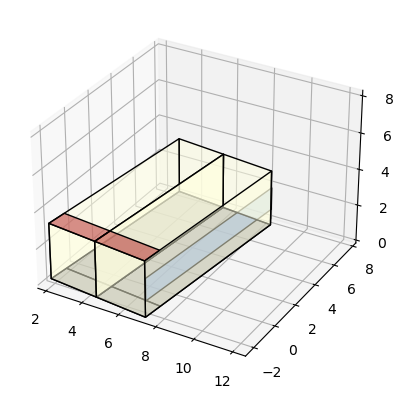

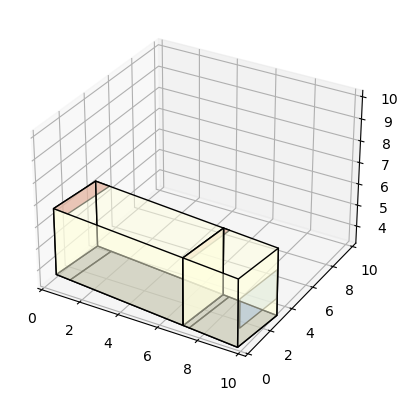

In [8]:
epw = "D:/Users/zoelh/GitRepos/ml-for-building-energy-modeling/ml-for-bem/data/epws/city_epws_indexed/cityidx_0000_USA_CA-Climate Zone 9.722880_CTZRV2.epw"
for i in indices:
    sb_info = umi.shoeboxdf.iloc[i]
    print(sb_info)
    sb = shoeboxes[sb_info['ShoeboxPath']]

    whitebox_sim = build_whitebox_from_umi(
        shoebox = sb,
        floor_2_facade = sb_info["Floor2Fac"],
        core_2_perim = sb_info["Core2Perimeter"],
        roof_2_footprint = sb_info["Roof2FloorRatio"],
        ground_2_footprint = sb_info["Ground2FloorRatio"],
        )
    # print(whitebox_sim.summarize())
    wb_hourly, wb_monthly = whitebox_sim.simulate()
    print(whitebox_sim.summarize())
    whitebox_sim.shoebox.view_model()
    sb.view_model()

In [10]:
sb.width

10.140300000000025

## Check whitebox output edits (OLD)

In [5]:
whitebox_sim = WhiteboxSimulation(schema, storage_vector)
whitebox_sim.summarize()

INFO:Schema:Skipping update of window parameters - will build simple window in build_shoebox




------------------------------
EPW: d:\Users\zoelh\GitRepos\ml-for-building-energy-modeling\ml-for-bem\data\epws\city_epws_indexed\cityidx_0000_USA_CA-Climate Zone 9.722880_CTZRV2.epw
Selected Template: PROG_03_VINTAGE_00_MASS_1
---ShoeboxConfig---
Height 3.0
Width 3.0
WWR 0.3
Facade2Foot 0.3
Perim2Foot 0.5
Foot2Gnd [adia %] 0.5
Roof2Gnd [adia %] 0.05
Orientation 0.0
---PERIM/CORE Values---
Heating Setpoint: 18.0 18.0
Cooling Setpoint: 24.0 24.0
Equipment Power Density: 7.0 7.0
Lighting Power Density: 3.0 3.0
People Density: 0.05 0.05
Infiltration: 1.0 1.0
Roof HeatCap: 12796.244999999999 12796.244999999999
Facade HeatCap: 12796.245 12796.245
U Window: 300.0
Roof RSI: 2.0
Facade RSI: 2.0
Slab RSI: 2.0
Partition RSI: 0.6526162790697675
Ground RSI: 2.0
Roof Assembly: [20:Fiberglass_Batts with thickness of 0.082 m, 14:Gypsum_Board with thickness of 0.015 m]
Facade Assembly: [20:Fiberglass_Batts with thickness of 0.082 m, 14:Gypsum_Board with thickness of 0.015 m]
Partition Assembly: [14

In [10]:
print(whitebox_sim.shoebox.idfobjects['WINDOWMATERIAL:SIMPLEGLAZINGSYSTEM'])
print(whitebox_sim.shoebox.idfobjects['FENESTRATIONSURFACE:DETAILED'])

[
WINDOWMATERIAL:SIMPLEGLAZINGSYSTEM,
    SimpleWindowMat_U1.0_SHGC0.5,    !- Name
    1,                        !- UFactor
    0.5;                      !- Solar Heat Gain Coefficient
]
[
FENESTRATIONSURFACE:DETAILED,
    Block Perim Storey 0 Wall 0004 window,    !- Name
    Window,                   !- Surface Type
    SimpleWindow_U1.0_SHGC0.5,    !- Construction Name
    Block Perim Storey 0 Wall 0004,    !- Building Surface Name
    ,                         !- Outside Boundary Condition Object
    autocalculate,            !- View Factor to Ground
    ,                         !- Frame and Divider Name
    1.0,                      !- Multiplier
    autocalculate,            !- Number of Vertices
    1.500000e-03,             !- Vertex 1 Xcoordinate
    0,                        !- Vertex 1 Ycoordinate
    1.95,                     !- Vertex 1 Zcoordinate
    1.500000e-03,             !- Vertex 2 Xcoordinate
    0,                        !- Vertex 2 Ycoordinate
    1.05,         

In [11]:
res_hourly, res_monthly = whitebox_sim.simulate()

C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-654cf844-5c10-11ee-bb57-004e01c02093.idf: 4.00it [00:00, 13.4it/s]
C:\EnergyPlusV9-2-0\energyplus.exe 654cf844-5c10-11ee-bb57-004e01c02093.idf: 55it [00:03, 18.00it/s]


In [12]:
whitebox_sim.shoebox.idfobjects['ZONEHVAC:IDEALLOADSAIRSYSTEM']

[
ZoneHVAC:IdealLoadsAirSystem,
    Block Perim Storey 0 Ideal Loads Air System,    !- Name
    ,                         !- Availability Schedule Name
    Block Perim Storey 0 Ideal Loads Supply Inlet,    !- Zone Supply Air Node Name
    ,                         !- Zone Exhaust Air Node Name
    ,                         !- System Inlet Air Node Name
    50,                       !- Maximum Heating Supply Air Temperature
    13,                       !- Minimum Cooling Supply Air Temperature
    0.0156,                   !- Maximum Heating Supply Air Humidity Ratio
    0.0077,                   !- Minimum Cooling Supply Air Humidity Ratio
    NoLimit,                  !- Heating Limit
    100,                      !- Maximum Heating Air Flow Rate
    100,                      !- Maximum Sensible Heating Capacity
    NoLimit,                  !- Cooling Limit
    100,                      !- Maximum Cooling Air Flow Rate
    100,                      !- Maximum Total Cooling Capacity


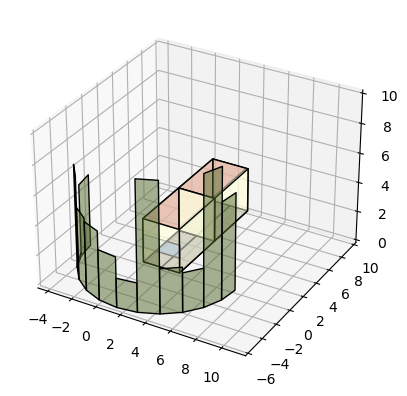

(<Figure size 640x480 with 1 Axes>, [<Axes3D: >])

In [13]:
# simulate first to see shading!
whitebox_sim.shoebox.view_model()

In [8]:
for out in whitebox_sim.schema.timeseries_outputs:
    print(out.var_name if out.key_name is None else out.key_name)

Zone Ideal Loads Zone Total Heating Energy
Zone Ideal Loads Zone Total Cooling Energy
Lights Total Heating Energy
Zone Windows Total Transmitted Solar Radiation Energy
Cooling:DistrictCooling
Heating:DistrictHeating
Zone Ideal Loads Supply Air Total Heating Energy
Zone Ideal Loads Supply Air Total Cooling Energy
Zone Ideal Loads Outdoor Air Total Heating Energy
Zone Ideal Loads Outdoor Air Total Cooling Energy


In [9]:
res_monthly


IndexGroup,Facility:DistrictHeating:Heating,Facility:DistrictCooling:Cooling
KeyValue,,
Name,Heating:DistrictHeating,Cooling:DistrictCooling
2018-01-01,6.542484e+08,1.451549e+08
2018-02-01,4.330184e+08,2.206827e+08
2018-03-01,3.687470e+08,1.884335e+08
2018-04-01,2.108675e+08,2.689301e+08
2018-05-01,6.791479e+07,3.075255e+08
2018-06-01,1.203078e+07,5.591559e+08
2018-07-01,3.150412e+04,9.877798e+08
2018-08-01,0.000000e+00,9.795303e+08


In [18]:
res_hourly.head()

IndexGroup                                                    System  \
KeyValue                 BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM   
Name                Zone Ideal Loads Supply Air Total Heating Energy   
2018-01-01 00:00:00                                         0.000000   
2018-01-01 01:00:00                                    129595.998602   
2018-01-01 02:00:00                                    378041.246208   
2018-01-01 03:00:00                                    619311.680120   
2018-01-01 04:00:00                                    744061.943396   

IndexGroup                                                            \
KeyValue                                                               
Name                Zone Ideal Loads Supply Air Total Cooling Energy   
2018-01-01 00:00:00                                              0.0   
2018-01-01 01:00:00                                              0.0   
2018-01-01 02:00:00                                              0.0   
2018-01-01 03:00:00                                              0.0   
2018-01-01 04:00:00                                              0.0   

IndexGroup                                                      \
KeyValue                                                         
Name                Zone Ideal Loads Zone Total Heating Energy   
2018-01-01 00:00:00                                   0.000000   
2018-01-01 01:00:00                              129595.998602   
2018-01-01 02:00:00                              378041.246208   
2018-01-01 03:00:00                              619311.680120   
2018-01-01 04:00:00                              744061.943396   

IndexGroup                                                      \
KeyValue                                                         
Name                Zone Ideal Loads Zone Total Cooling Energy   
2018-01-01 00:00:00                               0.000000e+00   
2018-01-01 01:00:00                               1.940847e-09   
2018-01-01 02:00:00                               6.266987e-09   
2018-01-01 03:00:00                               1.880096e-08   
2018-01-01 04:00:00                               2.207514e-08   

IndexGroup                                                            \
KeyValue                  BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM   
Name                Zone Ideal Loads Supply Air Total Heating Energy   
2018-01-01 00:00:00                                     5.743836e+05   
2018-01-01 01:00:00                                     7.379556e+05   
2018-01-01 02:00:00                                     8.710539e+05   
2018-01-01 03:00:00                                     1.028869e+06   
2018-01-01 04:00:00                                     1.076233e+06   

IndexGroup                                                            \
KeyValue                                                               
Name                Zone Ideal Loads Supply Air Total Cooling Energy   
2018-01-01 00:00:00                                              0.0   
2018-01-01 01:00:00                                              0.0   
2018-01-01 02:00:00                                              0.0   
2018-01-01 03:00:00                                              0.0   
2018-01-01 04:00:00                                              0.0   

IndexGroup                                                      \
KeyValue                                                         
Name                Zone Ideal Loads Zone Total Heating Energy   
2018-01-01 00:00:00                               5.743836e+05   
2018-01-01 01:00:00                               7.379556e+05   
2018-01-01 02:00:00                               8.710539e+05   
2018-01-01 03:00:00                               1.028869e+06   
2018-01-01 04:00:00                               1.076233e+06   

IndexGroup                                                      
KeyValue                                

In [20]:
res_monthly.sum()


IndexGroup                        KeyValue  Name                   
Facility:DistrictHeating:Heating            Heating:DistrictHeating    2.366676e+09
Facility:DistrictCooling:Cooling            Cooling:DistrictCooling    6.560333e+09
dtype: float64

In [29]:
res_hourly.sum()

IndexGroup  KeyValue                                     Name                                            
System      BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM  Zone Ideal Loads Supply Air Total Heating Energy    8.779674e+08
                                                         Zone Ideal Loads Supply Air Total Cooling Energy    5.268667e+09
                                                         Zone Ideal Loads Zone Total Heating Energy          8.779720e+08
                                                         Zone Ideal Loads Zone Total Cooling Energy          5.268671e+09
            BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM   Zone Ideal Loads Supply Air Total Heating Energy    1.488709e+09
                                                         Zone Ideal Loads Supply Air Total Cooling Energy    1.291667e+09
                                                         Zone Ideal Loads Zone Total Heating Energy          1.488710e+09
                                        